In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn import feature_extraction
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.pipeline import Pipeline

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
## Load data
csv_file_path = "loan.csv"

loan = pd.read_csv(csv_file_path, low_memory=False)

In [ ]:
#loan[['Current Loan Amount', 'y', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent','Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens']].corr()

In [4]:
# Remove duplicate and other missing rows
loan.isnull().sum()
loan.drop_duplicates(subset=['Loan ID'], inplace=True)
loan.dropna(subset=['Tax Liens'], inplace=True)
loan.dropna(thresh=17, inplace=True)


Loan ID                             0
Customer ID                         0
Loan Status                         0
Current Loan Amount                 0
Term                                0
Credit Score                    21338
Years in current job                0
Home Ownership                      0
Annual Income                   21338
Purpose                             0
Monthly Debt                        0
Years of Credit History             0
Months since last delinquent    59003
Number of Open Accounts             0
Number of Credit Problems           0
Current Credit Balance              0
Maximum Open Credit                 0
Bankruptcies                      228
Tax Liens                          11
dtype: int64

In [59]:
##Impute missing values with median
loan['Credit Score'] = loan['Credit Score'].fillna(value=loan['Credit Score'].median())
loan['Bankruptcies'] = loan['Bankruptcies'].fillna(value=loan['Bankruptcies'].median())
loan['Annual Income'] = loan['Annual Income'].fillna(value=loan['Annual Income'].median())
loan['Months since last delinquent'] = loan['Months since last delinquent'].fillna(value=loan['Months since last delinquent'].median())

In [6]:
loan.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Charged Off,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Charged Off,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Charged Off,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Charged Off,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Charged Off,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


In [7]:
for y in loan.columns:
    if(loan[y].dtype == 'object'):
          print y

Loan ID
Customer ID
Loan Status
Term
Years in current job
Home Ownership
Purpose
Monthly Debt
Maximum Open Credit


In [60]:
#Convert 'Monthly Debt' into float
loan['Monthly Debt'] = loan['Monthly Debt'].str.replace('$', '') #remove '$' from values before converting them to floats
loan['Monthly Debt'] = loan['Monthly Debt'].astype(float).fillna(loan['Monthly Debt'].median())

In [61]:
#Convert 'Maximum Open Credit' into float
loan = (loan.drop('Maximum Open Credit', axis=1)
	.join(loan['Maximum Open Credit'].apply(pd.to_numeric, errors='coerce')))
loan['Maximum Open Credit'] = loan['Maximum Open Credit'].fillna(value=loan['Maximum Open Credit'].median())

In [62]:
#encode 'Years in current job' into float
map_dict = {'n/a':0.0, '< 1 year':0.5, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, '6 years':6, '7 years':7, '8 years':8, '9 years':9, '10+ years':11}
loan['Years in current job'] = loan['Years in current job'].map(map_dict)

In [63]:
##separate target variable from train data
loan_target = loan['Loan Status']
loan_target = loan_target.map({'Fully Paid':1, 'Charged Off':0})
loan.drop(['Loan Status', 'Customer ID', 'Loan ID'], axis=1, inplace=True)

In [64]:
##Apply one-hot encoding
def one_hot_dataframe(data, cols, replace=False):
    vec = feature_extraction.DictVectorizer()
    mkdict = lambda row: dict((col, row[col]) for col in cols)
    vecData = pd.DataFrame(vec.fit_transform(data[cols].apply(mkdict, axis=1)).toarray())
    vecData.columns = vec.get_feature_names()
    vecData.index = data.index
    if replace:
        data = data.drop(cols, axis=1)
        data = data.join(vecData)
    return (data, vecData)

loan, loan_n = one_hot_dataframe(loan, ['Home Ownership', 'Purpose', 'Term'], replace=True)

In [65]:
#train and test data split 
X_train, X_test, y_train, y_test = train_test_split(loan, loan_target, test_size=0.20, random_state=33)

In [ ]:
##RandomForest
## GridSearchCV used for parameter optimization
param_grid = {'n_estimators': [100, 200, 300], 'max_features': [4, 6, 8]}
clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring=make_scorer(accuracy_score))
clf.fit(X_train, y_train)
clf.best_params_

In [31]:
##make model with best params
model_rf = RandomForestClassifier(n_estimators=300, max_features=6)
#model_rf = LogisticRegression(max_iter=300, random_state=1)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
print "RandomForest Accuracy:{0:.5f}".format(accuracy_score(y_test, y_pred)), "\n"

RandomForest Accuracy:0.78698 



In [32]:
##Feature importance table
feat_labels = X_train.columns
importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]
print "Printing Feature Importances of RandomForest"
for f in range(X_train.shape[1]):
    print "%2d) %-*s %f" % (f + 1, 40, feat_labels[f], importances[indices[f]])


Printing Feature Importances of RandomForest
 1) Current Loan Amount                      0.226496
 2) Credit Score                             0.143848
 3) Years in current job                     0.080945
 4) Annual Income                            0.080513
 5) Monthly Debt                             0.079912
 6) Years of Credit History                  0.078847
 7) Months since last delinquent             0.075296
 8) Number of Open Accounts                  0.053419
 9) Number of Credit Problems                0.051810
10) Current Credit Balance                   0.041134
11) Bankruptcies                             0.013846
12) Tax Liens                                0.013639
13) Maximum Open Credit                      0.008297
14) Home Ownership=HaveMortgage              0.007098
15) Home Ownership=Home Mortgage             0.006020
16) Home Ownership=Own Home                  0.005340
17) Home Ownership=Rent                      0.005036
18) Purpose=Business Loan            

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

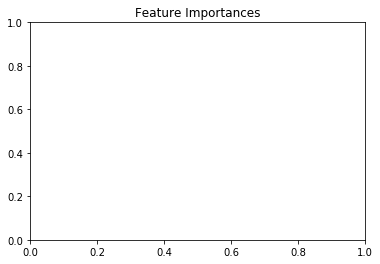

In [37]:
#Plot 'Feature Importances'
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices],
        color='lightgreen', align='center')

plt.xticks(range(X_train.shape[1]), feat_labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [36]:
#Feature Selection in RF
X_selected = model_rf.transform(X_train, threshold=0.01)
X_selected_test = model_rf.transform(X_test, threshold=0.01)
X_selected.shape

model_rf_new = RandomForestClassifier(n_estimators=300, max_features=6)
model_rf_new.fit(X_selected, y_train)

y_pred_new_train = model_rf_new.predict(X_selected)
print "Train_Accuracy:{0:.5f}".format(accuracy_score(y_train, y_pred_new_train)), "\n"

y_pred_new = model_rf_new.predict(X_selected_test)
print "Test_Accuracy:{0:.5f}".format(accuracy_score(y_test, y_pred_new)), "\n"


C:\Users\pushon\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\pushon\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


Train_Accuracy:1.00000 

Test_Accuracy:0.78523 



In [ ]:
##Feature extraction using PCA with pipeline
pipe_lr = Pipeline([
                    ('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
            
                    ('clf', RandomForestClassifier(n_estimators=300, max_features=6, random_state=0))])
                    #('clf', LogisticRegression(C=10.0, max_iter=500, random_state=0))])
pipe_lr.fit(X_train, y_train)
print('Train Accuracy: %.5f' % pipe_lr.score(X_train, y_train))
print('Test Accuracy: %.5f' % pipe_lr.score(X_test, y_test))

In [ ]:
#use different evaluation metrics

from sklearn.metrics import recall_score, f1_score, precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
f1_score(y_true=y_test, y_pred=y_pred)
roc_auc_score(y_true=y_test, y_score=y_pred)
accuracy_score(y_true=y_test, y_pred=y_pred)

In [ ]:
#Ensemle using LogisticRegression, RandomForestClassifier and GradientBoostingClassifier
# takes time therefore not used as default

def ensemble_classifier(X_train, X_test, y_train, y_test)
    sc = StandardScaler()
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)

    clf1 = LogisticRegression(max_iter=300, random_state=1)
    clf2 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.07, max_features=6, random_state=0)
    clf3 = RandomForestClassifier(n_estimators=200, max_features=7, random_state=1)
    eclf = VotingClassifier(estimators=[('lr', clf1), ('gnb', clf2), ('rf', clf3)], voting='soft', weights=[3,2,4])

    params = {'lr__max_iter': [300, 500], 'rf__n_estimators': [200]}

    grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
    grid = grid.fit(X_train_std, y_train)

    y_pred_ens = grid.predict(X_test_std)

    print('Ensemble Test Accuracy: %.5f' % accuracy_score(y_test, y_pred_ens))

In [ ]:
##Implement Bagging with d

clf_gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=0.07, max_features=6, random_state=0)
bag = BaggingClassifier(base_estimator=clf_gbc, n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True, bootstrap_features=False,
                        n_jobs=1, random_state=1)

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.4f/%.4f' % (bag_train, bag_test))